In [41]:
import numpy as np
from pylab import *
from scipy import ndimage
from scipy import misc
from scipy import linalg
from scipy import argsort
from scipy import signal
from scipy import interpolate
import os
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py as h5

%matplotlib inline
rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

import mayavi.mlab as mlab
%load_ext imayavi

In [48]:
# %load fibers.py
import numpy as np
from scipy import signal, linalg, argsort


def ndautocorr(V, insz, window=None, beta=1, normalize=True):
    """
    Autocorrelation of a volume V with a smaller subvolume of itself

    :param V: Volume
    :param insz: Size of the smaller region.  Will be centered
    :param window: None, 'hamming', or 'kaiser'
    :param beta: Kaiser beta parameter
    :param normalize: If True, normalizes the volume by subtracting the mean and dividing by the standard deviation.
    :return: Returns the autocorrelation matrix
    """
    outsz = V.shape

    if normalize:
        V = (V-np.mean(V))/np.std(V)

    if window is not None:
        if window == 'hamming':
            windowfcn = np.hamming
        elif window == 'kaiser':
            windowfcn = lambda x: np.kaiser(x,beta=beta)
        else:
            raise ValueError('Unrecognized window function')

        W = np.ones((outsz[0]))
        for dim1,outsz1 in enumerate(outsz):
            # make the window on one axis
            w1 = windowfcn(outsz1)
            # set up a slice to broadcast along the current dimension
            ss = [np.newaxis for i in outsz]
            ss[dim1] = slice(None)
            # and multiply to build up the ND window
            W = W * w1[ss]

        V = V*W

    inrng = [slice(out1//2-in1//2, out1//2-in1//2 + in1)
            for (in1,out1) in zip(insz,outsz)]
    outrng = [slice(None,None,-1) for in1 in insz]

    C = signal.fftconvolve(V[outrng],V[inrng],mode='valid')

    return C


def hessian(C, ctr=None, di=1):
    """
    Returns the Hessian matrix of C, evaluated at the point ctr, given a spacing di.
    Uses 5th order central difference approximations to the derivative.

    :param C: 2 or 3D ndarray
    :param ctr: Point at which to evaluate the Hessian
    :param di: Spacing between points in C
    :return: Returns the Hessian matrix
    """

    # 5th order derivatives
    # first derivative
    a1 = np.array([-1.0, 9.0, -45.0, 0.0, 45.0, -9.0, 1.0])/60
    # second derivative
    a2 = np.array([2, -27, 270, -490, 270, -27, 2])/180.0

    # round down
    n = len(a1)//2
    if ctr is None:
        # round up if lengths are odd
        ctr = (np.array(C.shape)+1)//2

    ic = np.arange(-n,n+1)

    nd = C.ndim
    assert((nd == 2) or (nd == 3))

    H = np.zeros((nd,nd))

    # get second derivatives along the diagonal
    for i in xrange(nd):
        r = list(ctr)
        r[i] += ic
        H[i,i] = sum(C[tuple(r)] * a2) / di**2

    # cross derivatives off diagonal
    ic1 = ic[:,np.newaxis]
    ic2 = ic[np.newaxis,:]

    for i in xrange(nd):
        for j in xrange(i+1,nd):
            r = list(ctr)
            r[i] += ic1
            r[j] += ic2
            H[i,j] = np.sum( np.sum( C[tuple(r)] * a1[:,np.newaxis], axis=0) * a1) / di**2

            # mirror the cross derivatives
            H[j,i] = H[i,j]

    return H


def fiber_angle(V, insz, returncorr=False, **kw):
    """
    Estimate the angle of fibers through a volume.
    First takes the autocorrelation of the volume, then takes the eigenvalues and eigenvectors of the Hessian
    matrix at the center of the autocorrelation volume.  The eigenvector corresponding to the smallest magnitude
    (negative) eigenvalue is the dominant angle

    Extra keyword parameters are passed on to the ndautocorr function.

    :param V: Volume.  2 or 3D array
    :param insz: Size of the smaller region to use for the autocorrelation
    :param returncorr: True to return the autocorrelation matrix
    :return: vr, w, C: Eigenvectors and eigenvalues.  Sorted from smallest magnitude to largest.  C is the
    autocorrelation matrix, if returncorr is True
    """

    # get the autocorrelation
    C = ndautocorr(V, insz, **kw)
    ctr = (np.array(V.shape) - np.array(insz)+1)//2

    # and the hessian in the center
    H = hessian(C, ctr=ctr)

    # then eigenvalues and eigenvectors of the Hessian matrix
    w,vr = linalg.eig(H)

    # look for the smallest magnitude eigenvalue
    order = argsort(np.abs(w))
    vr = vr[:, order]
    w = w[order]

    if returncorr:
        return vr, w, C
    else:
        return vr, w

# Load Danio data

In [3]:
infile = 'Drerio4.h5'

In [4]:
f = h5.File(infile,'a')
imgdata = f['image']
print imgdata.shape

(690, 1235, 2237)


In [27]:
gridsize = 32
gridoverlap = 0.5

gridi = np.arange(gridsize,imgdata.shape[0]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))
gridj = np.arange(gridsize,imgdata.shape[1]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))
gridk = np.arange(gridsize,imgdata.shape[2]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))

In [71]:
grid = np.zeros((3,len(gridi),len(gridj),len(gridk)),dtype=np.int)

#broadcast the grid locations across the new matrix
grid[0,:,:,:] = gridi[:,np.newaxis,np.newaxis]
grid[1,:,:,:] = gridj[np.newaxis,:,np.newaxis]
grid[2,:,:,:] = gridk[np.newaxis,np.newaxis,:]

## Load one volume and test

In [72]:
print (len(gridi), len(gridj), len(gridk))

(40, 74, 136)


In [73]:
ex = (17,25,61)
print grid[(slice(None),)+ex]

[ 304  432 1008]


In [74]:
gridsz2 = (gridsize+1)//2
rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in grid[(slice(None),)+ex]]
I1 = imgdata[rng[0],rng[1],rng[2]]

In [75]:
i = np.arange(I1.shape[0]) - I1.shape[0]/2
[i,j,k] = meshgrid(i,i,i, indexing='ij')

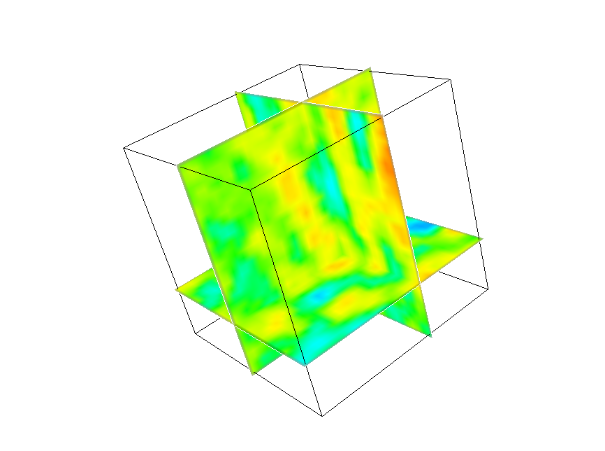

In [76]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(i,j,k, I1, colormap='cool')

mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                slice_index=int(i.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                slice_index=int(i.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(i.shape[2]/2))
mlab.outline()

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [59]:
vr,w,C = fiber_angle(I1, (24,24,24), returncorr=True)

a = np.arange(C.shape[0]) - C.shape[0]/2
[a,b,c] = meshgrid(a,a,a, indexing='ij')

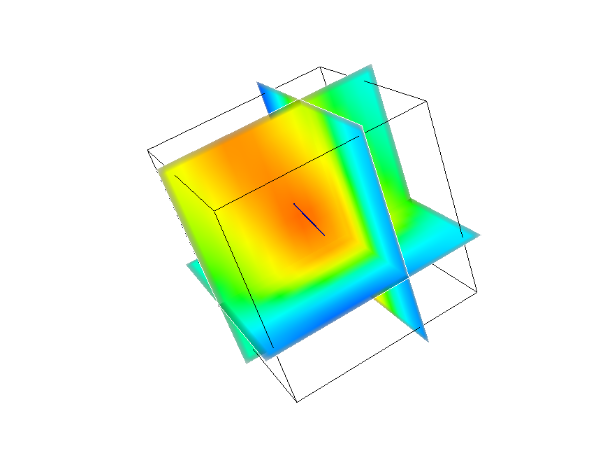

In [61]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(a,b,c, C)

mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                slice_index=int(a.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                slice_index=int(a.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(a.shape[2]/2))
mlab.outline()

mlab.plot3d([-vr[0,0],vr[0,0]],[-vr[1,0],vr[1,0]],[-vr[2,0],vr[2,0]], color=(0,0,0.7))

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

# Get the volume statistics

In [87]:
csz = imgdata.chunks
chunks = [np.mean(imgdata[a:a+csz[0], b:b+csz[1], c:c+csz[2]]) for a in np.arange(0,imgdata.shape[0],csz[0]) 
          for b in np.arange(0,imgdata.shape[1],csz[1])
          for c in np.arange(0,imgdata.shape[2],csz[2])]

In [91]:
imgdatamean = np.mean(chunks)
imgdatastd = np.std(chunks)

print "Mean: {}, Stdev: {}".format(imgdatamean, imgdatastd)

Mean: 8557.16815275, Stdev: 8277.73486723


# Run through the whole volume

In [ ]:
eigvecs = np.zeros((3,)+grid.shape[1:])
eigvals = np.zeros((3,3)+grid.shape[1:])
means = np.zeros(grid.shape[1:])
gridsz2 = (gridsize+1)//2

from IPython.html.widgets import FloatProgress
from IPython.display import display

f = FloatProgress(min=0,max=np.prod(grid.shape))
display(f)

for i in xrange(grid.shape[1]):
    for j in xrange(grid.shape[2]):
        for k in xrange(grid.shape[3]):
            rng = [slice(grid1-gridsz2,grid1+gridsz2) for grid1 in grid[:,i,j,k]]
            I1 = imgdata[rng[0],rng[1],rng[2]].astype(float)/65536
            
            if np.mean(I1) > 0.5*imgdatamean:
                vr1,w1 = fiber_angle(I1, insz=insz, normalize=True)

                eigvals[:,i,j,k] = real(w1)
                eigvecs[:,:,i,j,k] = vr1                
                
            f.value += 1